# 3 Methodology

## 3.2 Exploratory Data Analysis

### Answer the following questions
- What can be derived from the correlation analysis?
- What can be derived from the numerical statistical analysis?
- How satisfied are employees with their job in general?
- Did more women or men voluntary left the company?
- What is the marital status and age of the majority of departed emplyoees?
- To which departments did the most voluntary exits belong to?

In [2]:
# packages to load

import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re

from sklearn.model_selection import RepeatedKFold, cross_val_score
from torch.utils.data import DataLoader,TensorDataset,random_split,SubsetRandomSampler
from scipy import stats
from functools import reduce

# Some matplotlib options
%matplotlib inline
matplotlib.style.use("ggplot")

# General pandas options
pd.set_option('display.max_colwidth', None)  # Show the entire column 
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 10000 

# Seaborn options
sns.set_style("whitegrid")

In [6]:
# load the data set
employee_turnover_data =pd.read_csv(r'./WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [7]:
# obtain the dimensions of the dataframe object
# inspect how many records and features there are in the dataset, 1470 records and 35 attributes
employee_turnover_data.shape

(1470, 35)

In [4]:
# Obtain first few rows of the dataset
#employee_turnover_data.head()
employee_turnover_data['Age'].min()

18

In [5]:
# get the names of all the columns of the dataframe in descriptive format
employee_turnover_data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### Exploratory Data Analysis

#### What is the number of employees who have left in comparison to those who are still with the company?

In [6]:
employee_turnover_data['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

#### How satisfied are employees with their job in general?

In [7]:
employee_turnover_data['JobSatisfaction'].value_counts()

4    459
3    442
1    289
2    280
Name: JobSatisfaction, dtype: int64

#### What can be derived from the correlation analysis?

In [8]:
# Half the rows in JobSatisfaction seem to be strings. 
# It's the same for the other columns. Let's cast them to floats.
cols = ['JobSatisfaction', 'HourlyRate', 'MonthlyIncome', 'PercentSalaryHike']
employee_turnover_data[cols] = employee_turnover_data[cols].applymap(np.float64)

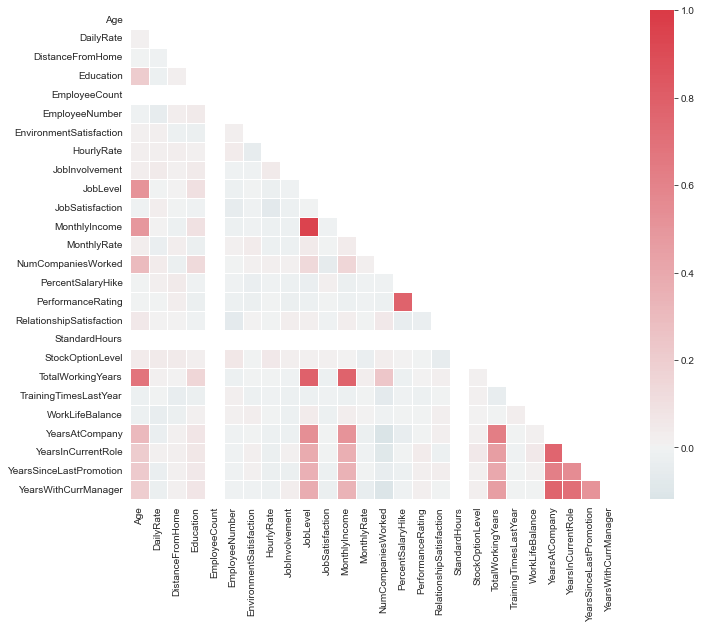

In [9]:
# Subset the dataset into all the numerical values
numeric_hr = employee_turnover_data.select_dtypes(include=[np.number])

# Compete the correlation matrix
corr = numeric_hr._get_numeric_data().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0,
                      vmax = 1, square=True, linewidths=.5, ax=ax)
plt.savefig('corr-heat.png')
plt.show()

#### What can be derived from the numerical statistical analysis?

In [10]:
employee_turnover_data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


#### Did more women or men voluntary left the company?

In [11]:
# get the number of employees who are (not)working for the company
current_employees = employee_turnover_data[employee_turnover_data['Attrition'] == 'No']
ex_employees = employee_turnover_data[employee_turnover_data['Attrition'] == 'Yes']
current_employees.shape

(1233, 35)

In [12]:
# Resignations grouped by gender
# more men have resigned compared to women
ex_employees.groupby('Gender')['EmployeeNumber'].count()

Gender
Female     87
Male      150
Name: EmployeeNumber, dtype: int64

#### What is the marital status and age of the majority of departed employees?

In [13]:
ex_employees.groupby('MaritalStatus')['EmployeeNumber'].count()

MaritalStatus
Divorced     33
Married      84
Single      120
Name: EmployeeNumber, dtype: int64

#### What age group do departed employees belong to?

In [14]:
ex_employees.groupby(pd.cut(ex_employees['Age'], np.arange(17, 74, 8)))['Age'].count()
#ex_employees.groupby('Age')['EmployeeNumber'].count()

Age
(17, 25]    44
(25, 33]    97
(33, 41]    50
(41, 49]    23
(49, 57]    18
(57, 65]     5
(65, 73]     0
Name: Age, dtype: int64

#### To which departments did the most voluntary exits belong to?

In [15]:
ex_employees.groupby('Department')['EmployeeNumber'].count()

Department
Human Resources            12
Research & Development    133
Sales                      92
Name: EmployeeNumber, dtype: int64

## 3.3 Data Preprocessing steps

Steps:

__1. Data Cleaning__
- Check for missing values
- Drop duplicate records

__2. Data Transformation__
- Convert categorical and string data types to numerical type
- Set the target feature

__3. Data Reduction__
- Remove columns with a lack of cardinality

### 3.3.1 Data Cleaning

In [16]:
#### Check for missing values and duplicates

# check for missiong values
are_values_missing = employee_turnover_data.isnull().values.any()
print(f'Are values missing? {are_values_missing}')

# drop duplicate records and do not create another copy of the dataframe
employee_turnover_data.drop_duplicates(inplace=True)

Are values missing? False


### 3.3.2 Data Transformation

In [17]:
# obtain the dimensions of the dataframe object
# inspect how many records and features there are in the dataset, 1470 records and 35 attributes
employee_turnover_data.shape

(1470, 35)

In [18]:
# check the datatype of the columns and number of entries in each
# we have two different datatypes, int64 and object
# we will have to convert object data types to numneric as well, as most of ML models work with numbers
employee_turnover_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1470 non-null   int64  
 1   Attrition                 1470 non-null   object 
 2   BusinessTravel            1470 non-null   object 
 3   DailyRate                 1470 non-null   int64  
 4   Department                1470 non-null   object 
 5   DistanceFromHome          1470 non-null   int64  
 6   Education                 1470 non-null   int64  
 7   EducationField            1470 non-null   object 
 8   EmployeeCount             1470 non-null   int64  
 9   EmployeeNumber            1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   float64
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

In [19]:
# Create a dataframe for holding the nomalized data
transformed_turnover_data = employee_turnover_data.copy()

# create separate continuous and categorical dataframes

## Create a dataframe with numerical columns 
numeric_df = employee_turnover_data.select_dtypes(include = ['int64', 'float64'])
print(f'Numerical columns:\n{list(numeric_df.columns.values)}\n')

## Create a dataframe with categorical columns 
categoric_df = employee_turnover_data.select_dtypes(include =['object'])
print(f'Numerical columns:\n{list(categoric_df.columns.values)}\n')

Numerical columns:
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Numerical columns:
['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']



#### Transform ordinal categories

BusinessTravel is ordinal data where there is a relationship:  
Non-Travel < Travel_Rarely < Travel_Frequently  

Therefore BusinessTravel will maps its values  
Non-Travel, Travel_Rarely, Travel_Frequently to numeric values 0, 1, 2

In [20]:
transformed_turnover_data['BusinessTravel'] = employee_turnover_data['BusinessTravel'].map(
    {'Non-Travel':0.0 ,'Travel_Rarely':1.0,'Travel_Frequently':2.0})
transformed_turnover_data['BusinessTravel'].head(10)

0    1.0
1    2.0
2    1.0
3    2.0
4    1.0
5    2.0
6    1.0
7    1.0
8    2.0
9    1.0
Name: BusinessTravel, dtype: float64

#### Transform multi-value nominal categories
Categorical features that are nominal if the data values have no relationship with each other.
Such nominal features with more than 2 distinct values with be pre-processed using Effect Encoding (or Sum Encoding), which creates a column per distinct value, except for one. The new columns are encoded with __1__ if the value is present and __0__ if the value is absent. If all the distict value columns are encoded with __-1__, this indicates the presence of the one distinc value which does not have a column.

| Deparment | Department_Sales | Department_Research_Development |
| --- | --- | --- |
| Sales | 1 | 0 |
| Research & Development | 0 | 1 |
| Human Resources | -1 | -1 |

In [21]:
# All multi-value nominal categories
nominal_categories = ['Department','EducationField','JobRole', 'MaritalStatus']
nominal_distinct_values = {}

# What are the distinct values of each nominal category
for nominal_category in nominal_categories:
    nominal_distinct_values[nominal_category] = employee_turnover_data[nominal_category].unique()
    print(f'Distinct values for {nominal_category}: {nominal_distinct_values[nominal_category]}')

Distinct values for Department: ['Sales' 'Research & Development' 'Human Resources']
Distinct values for EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Distinct values for JobRole: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
Distinct values for MaritalStatus: ['Single' 'Married' 'Divorced']


In [22]:
# Apply effect encoding for nominal multivalue columns

from category_encoders.sum_coding import SumEncoder

sum_encoder = SumEncoder(cols=nominal_categories,verbose=False,drop_invariant=True,return_df=True,)
nominal_categories_df = sum_encoder.fit_transform(employee_turnover_data[nominal_categories])
new_nominal_columns = list(nominal_categories_df.columns.values)
transformed_turnover_data.drop(columns=new_nominal_columns, errors='ignore', inplace=True)
transformed_turnover_data.drop(columns=nominal_categories, errors='ignore', inplace=True)
transformed_turnover_data = transformed_turnover_data.join(nominal_categories_df)

#transformed_turnover_data
column_mapping = {}
for nominal_category, distinct_values in nominal_distinct_values.items():
    for index, value in enumerate(distinct_values):
        if index != len(distinct_values) - 1:
            current_column_name = f'{nominal_category}_{index}'
            clean_name = value.replace('&', '').replace('  ', '_').replace(' ', '_')
            new_column_name = f'{nominal_category}_{clean_name}'
            column_mapping[current_column_name] = new_column_name

transformed_turnover_data.rename(columns=column_mapping, inplace=True)

transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,41,Yes,1.0,1102,1,2,1,1,2,Female,94.0,3,2,4.0,5993.0,19479,8,Y,Yes,11.0,3,1,80,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,49,No,2.0,279,8,1,1,2,3,Male,61.0,2,2,2.0,5130.0,24907,1,Y,No,23.0,4,4,80,1,10,3,3,10,7,1,7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,37,Yes,1.0,1373,2,2,1,4,4,Male,92.0,2,1,3.0,2090.0,2396,6,Y,Yes,15.0,3,2,80,0,7,3,3,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33,No,2.0,1392,3,4,1,5,4,Female,56.0,3,1,3.0,2909.0,23159,1,Y,Yes,11.0,3,3,80,0,8,3,3,8,7,3,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27,No,1.0,591,2,1,1,7,1,Male,40.0,3,1,2.0,3468.0,16632,9,Y,No,12.0,3,4,80,1,6,3,3,2,2,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Transform boolean nominal data

Text labels such as 'Yes' or 'No' are used for representing boolean data. These labels will be replaced by numeric data such as 1.0 and 0.0.

In [23]:
nominal_boolean_mapping = {
    'Attrition': {'Yes': 1.0, 'No': 0.0},
    'Gender': {'Female': 1.0, 'Male': 0.0}, 
    'OverTime': {'Yes': 1.0, 'No': 0.0}
}
for column, mapping in nominal_boolean_mapping.items():
    transformed_turnover_data[column] = employee_turnover_data[column].map(mapping)

transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,41,1.0,1.0,1102,1,2,1,1,2,1.0,94.0,3,2,4.0,5993.0,19479,8,Y,1.0,11.0,3,1,80,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,49,0.0,2.0,279,8,1,1,2,3,0.0,61.0,2,2,2.0,5130.0,24907,1,Y,0.0,23.0,4,4,80,1,10,3,3,10,7,1,7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,37,1.0,1.0,1373,2,2,1,4,4,0.0,92.0,2,1,3.0,2090.0,2396,6,Y,1.0,15.0,3,2,80,0,7,3,3,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33,0.0,2.0,1392,3,4,1,5,4,1.0,56.0,3,1,3.0,2909.0,23159,1,Y,1.0,11.0,3,3,80,0,8,3,3,8,7,3,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27,0.0,1.0,591,2,1,1,7,1,0.0,40.0,3,1,2.0,3468.0,16632,9,Y,0.0,12.0,3,4,80,1,6,3,3,2,2,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Standardize Numerical Data
Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

In [24]:
numeric_columns = []
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()

trasformed_numeric_df = pd.DataFrame(trans.fit_transform(numeric_df), 
                                columns=numeric_df.columns,
                                index=numeric_df.index)

transformed_turnover_data.replace(trasformed_numeric_df, inplace=True)

transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,0.214286,1.0,1.0,0.755190,0.250000,0.25,0.0,0.000484,1.000000,1.0,0.814286,0.666667,0.00,0.333333,5993.0,19479,0.000000,Y,1.0,0.071429,0.0,1.000000,0.0,0.000000,0.250,0.0,0.666667,0.025,0.111111,0.000000,0.352941,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.404762,0.0,2.0,0.497495,0.785714,0.00,0.0,0.001451,1.000000,0.0,0.285714,0.333333,0.00,0.666667,5130.0,24907,0.111111,Y,0.0,0.214286,0.0,1.000000,0.0,0.333333,0.150,0.5,0.666667,0.125,0.000000,0.066667,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.404762,1.0,1.0,0.924839,0.035714,0.25,0.0,0.002903,0.000000,0.0,0.471429,0.333333,0.25,0.666667,2090.0,2396,0.444444,Y,1.0,0.000000,0.0,0.333333,0.0,0.000000,0.025,0.5,0.666667,0.150,0.222222,0.000000,0.294118,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,0.0,2.0,0.803150,0.071429,0.00,0.0,0.003387,0.000000,1.0,0.585714,0.666667,0.25,0.666667,2909.0,23159,0.111111,Y,1.0,0.071429,0.0,0.666667,0.0,0.000000,0.250,0.5,0.666667,0.225,0.000000,0.200000,0.294118,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.571429,0.0,1.0,0.011453,0.035714,0.00,0.0,0.004838,0.666667,0.0,0.642857,0.666667,0.25,0.666667,3468.0,16632,0.666667,Y,0.0,0.428571,0.0,1.000000,0.0,0.333333,0.300,0.5,0.666667,0.000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3.3.3 Data Reduction

Remove data with low-cardinality (low variance) such as EmployeeCount, StandardHours and Over18.

In [25]:
transformed_turnover_data.drop(columns=['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], errors='ignore', inplace=True)
transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,0.214286,1.0,1.0,0.755190,0.250000,0.25,1.000000,1.0,0.814286,0.666667,0.00,0.333333,5993.0,19479,0.000000,1.0,0.071429,0.0,1.000000,0.000000,0.250,0.0,0.666667,0.025,0.111111,0.000000,0.352941,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.404762,0.0,2.0,0.497495,0.785714,0.00,1.000000,0.0,0.285714,0.333333,0.00,0.666667,5130.0,24907,0.111111,0.0,0.214286,0.0,1.000000,0.333333,0.150,0.5,0.666667,0.125,0.000000,0.066667,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.404762,1.0,1.0,0.924839,0.035714,0.25,0.000000,0.0,0.471429,0.333333,0.25,0.666667,2090.0,2396,0.444444,1.0,0.000000,0.0,0.333333,0.000000,0.025,0.5,0.666667,0.150,0.222222,0.000000,0.294118,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,0.0,2.0,0.803150,0.071429,0.00,0.000000,1.0,0.585714,0.666667,0.25,0.666667,2909.0,23159,0.111111,1.0,0.071429,0.0,0.666667,0.000000,0.250,0.5,0.666667,0.225,0.000000,0.200000,0.294118,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.571429,0.0,1.0,0.011453,0.035714,0.00,0.666667,0.0,0.642857,0.666667,0.25,0.666667,3468.0,16632,0.666667,0.0,0.428571,0.0,1.000000,0.333333,0.300,0.5,0.666667,0.000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3.3.4 Data Imbalance

#### Check for data imbalances

The employees with attrition 'Yes' represent only 16% of the dataset, which could create bias in the model.

In [26]:
# Split into features and target dataframes
df_target = transformed_turnover_data.loc[:, transformed_turnover_data.columns == 'Attrition']
df_features = transformed_turnover_data.loc[:, transformed_turnover_data.columns != 'Attrition']

# check yes/no ratio
# number of no records is much smaller than yes records, which could bias the model
transformed_turnover_data['Attrition'].value_counts()

0.0    1233
1.0     237
Name: Attrition, dtype: int64

In [27]:
# Convert dataframe to tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor_features = torch.from_numpy(df_features.values).float().to(device)
tensor_target = torch.from_numpy(df_target.values).view(1, -1)[0].long().to(device)

## 3.4 Modeling

### 3.4.1 Neural Network design

#### Setup the input and output size of NN

In [28]:
# Define the parameters for the neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

input_size = len(df_features.columns)
output_size = len(df_target['Attrition'].unique())

print(f'NN input size {input_size} and output size {output_size}')

NN input size 43 and output size 2


#### Create Custom NN class by extending nn.Module

The custom class that will hold all our NN state is called Net.

In [29]:
class Net(nn.Module):
    
    def __init__(self,hidden_size, activation_fn = 'relu', apply_dropout=False): 
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        self.dropout = None
        if apply_dropout:
            self.dropout = nn.Dropout(0.2)

    
    def forward(self, x):
        
        activation_fn = None
        if  self.activation_fn == 'sigmoid':
                activation_fn = F.torch.sigmoid

        elif self.activation_fn == 'tanh':
                activation_fn = F.torch.tanh

        elif self.activation_fn == 'relu':
                 activation_fn = F.relu

        x = activation_fn(self.fc1(x))
        x = activation_fn(self.fc2(x))

        if self.dropout != None:
            x = self.dropout(x)

        x = self.fc3(x)
        return F.log_softmax(x, dim = -1)

In [30]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()

    for X, y in dataloader:

        X,y = X.to(device),y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = loss_fn(Y_pred,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        scores, predictions = torch.max(Y_pred.data, 1)
        train_correct += (predictions == y).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for X, y in dataloader:

        X,y = X.to(device),y.to(device)
        Y_pred = model(X)
        loss=loss_fn(Y_pred,y)
        valid_loss+=loss.item()*X.size(0)
        scores, predictions = torch.max(Y_pred.data,1)
        val_correct+=(predictions == y).sum().item()

    return valid_loss,val_correct, y.cpu().detach().numpy(), predictions.cpu().detach().numpy()

#### Model with 3 hidden layers and 19 neuron/layer and ReLu activation function

In [31]:
net = Net(hidden_size=19, activation_fn='relu', apply_dropout=False).to(device)

net

Net(
  (fc1): Linear(in_features=43, out_features=19, bias=True)
  (fc2): Linear(in_features=19, out_features=19, bias=True)
  (fc3): Linear(in_features=19, out_features=19, bias=True)
  (fc4): Linear(in_features=19, out_features=19, bias=True)
  (fc5): Linear(in_features=19, out_features=2, bias=True)
)

### 3.4.2 Train and Evaluate Model

To properly train and evaluate the model, k-fold cross validation is used. The dataset, with 1470 records, is divided in batches of size 147, resulting thus in 10 batches. 
The 20-fold cross validation technique with 2 repeats is then applied to each batch. The number of epochs is initialized to 1000, meaning that one epoch involves 10 batches and 10 updates of the model. 

In [32]:
num_epochs=1000
batch_size=147
k=20
repeats=2
foldperf={}
loss_fn = nn.NLLLoss()

predicted_targets = np.array([])
actual_targets = np.array([])
    
kf = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state = 2)

dataset = TensorDataset(tensor_features, tensor_target)

for fold, (train_idx,val_idx) in enumerate(kf.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0007)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(net,device,train_loader,loss_fn,optimizer)
        test_loss, test_correct, y_actual, y_predicted=valid_epoch(net,device,test_loader,loss_fn)
        
        predicted_targets = np.append(predicted_targets, y_predicted)
        actual_targets = np.append(actual_targets, y_actual)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        if (epoch + 1) % 100 == 0:
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history

Fold 1
Epoch:100/1000 AVG Training Loss:0.861 AVG Test Loss:1.125 AVG Training Acc 75.21 % AVG Test Acc 86.49 %
Epoch:200/1000 AVG Training Loss:0.445 AVG Test Loss:0.423 AVG Training Acc 82.95 % AVG Test Acc 86.49 %
Epoch:300/1000 AVG Training Loss:0.434 AVG Test Loss:0.522 AVG Training Acc 83.38 % AVG Test Acc 86.49 %
Epoch:400/1000 AVG Training Loss:0.392 AVG Test Loss:0.433 AVG Training Acc 84.24 % AVG Test Acc 85.14 %
Epoch:500/1000 AVG Training Loss:0.517 AVG Test Loss:0.492 AVG Training Acc 80.87 % AVG Test Acc 86.49 %
Epoch:600/1000 AVG Training Loss:0.520 AVG Test Loss:0.743 AVG Training Acc 79.58 % AVG Test Acc 86.49 %
Epoch:700/1000 AVG Training Loss:0.369 AVG Test Loss:0.527 AVG Training Acc 85.46 % AVG Test Acc 79.73 %
Epoch:800/1000 AVG Training Loss:0.530 AVG Test Loss:0.549 AVG Training Acc 80.09 % AVG Test Acc 86.49 %
Epoch:900/1000 AVG Training Loss:0.393 AVG Test Loss:0.503 AVG Training Acc 84.24 % AVG Test Acc 79.73 %
Epoch:1000/1000 AVG Training Loss:0.441 AVG Test

Epoch:900/1000 AVG Training Loss:0.288 AVG Test Loss:0.323 AVG Training Acc 88.54 % AVG Test Acc 86.49 %
Epoch:1000/1000 AVG Training Loss:0.283 AVG Test Loss:0.307 AVG Training Acc 88.47 % AVG Test Acc 86.49 %
Fold 9
Epoch:100/1000 AVG Training Loss:0.316 AVG Test Loss:0.311 AVG Training Acc 86.89 % AVG Test Acc 82.43 %
Epoch:200/1000 AVG Training Loss:0.282 AVG Test Loss:0.312 AVG Training Acc 88.47 % AVG Test Acc 86.49 %
Epoch:300/1000 AVG Training Loss:0.307 AVG Test Loss:0.350 AVG Training Acc 87.89 % AVG Test Acc 86.49 %
Epoch:400/1000 AVG Training Loss:0.289 AVG Test Loss:0.392 AVG Training Acc 88.18 % AVG Test Acc 85.14 %
Epoch:500/1000 AVG Training Loss:0.277 AVG Test Loss:0.413 AVG Training Acc 89.33 % AVG Test Acc 82.43 %
Epoch:600/1000 AVG Training Loss:0.262 AVG Test Loss:0.496 AVG Training Acc 90.04 % AVG Test Acc 81.08 %
Epoch:700/1000 AVG Training Loss:0.251 AVG Test Loss:0.434 AVG Training Acc 90.26 % AVG Test Acc 87.84 %
Epoch:800/1000 AVG Training Loss:0.254 AVG Test

Epoch:700/1000 AVG Training Loss:0.198 AVG Test Loss:0.372 AVG Training Acc 91.34 % AVG Test Acc 83.56 %
Epoch:800/1000 AVG Training Loss:0.208 AVG Test Loss:0.340 AVG Training Acc 92.05 % AVG Test Acc 86.30 %
Epoch:900/1000 AVG Training Loss:0.176 AVG Test Loss:0.362 AVG Training Acc 92.70 % AVG Test Acc 82.19 %
Epoch:1000/1000 AVG Training Loss:0.199 AVG Test Loss:0.327 AVG Training Acc 92.05 % AVG Test Acc 86.30 %
Fold 17
Epoch:100/1000 AVG Training Loss:0.193 AVG Test Loss:0.160 AVG Training Acc 92.63 % AVG Test Acc 94.52 %
Epoch:200/1000 AVG Training Loss:0.210 AVG Test Loss:0.143 AVG Training Acc 90.91 % AVG Test Acc 94.52 %
Epoch:300/1000 AVG Training Loss:0.199 AVG Test Loss:0.170 AVG Training Acc 91.91 % AVG Test Acc 91.78 %
Epoch:400/1000 AVG Training Loss:0.211 AVG Test Loss:0.178 AVG Training Acc 91.55 % AVG Test Acc 94.52 %
Epoch:500/1000 AVG Training Loss:0.219 AVG Test Loss:0.165 AVG Training Acc 91.34 % AVG Test Acc 91.78 %
Epoch:600/1000 AVG Training Loss:0.214 AVG Tes

Epoch:500/1000 AVG Training Loss:0.166 AVG Test Loss:0.207 AVG Training Acc 93.34 % AVG Test Acc 90.54 %
Epoch:600/1000 AVG Training Loss:0.221 AVG Test Loss:0.197 AVG Training Acc 91.12 % AVG Test Acc 91.89 %
Epoch:700/1000 AVG Training Loss:0.186 AVG Test Loss:0.309 AVG Training Acc 92.12 % AVG Test Acc 90.54 %
Epoch:800/1000 AVG Training Loss:0.186 AVG Test Loss:0.216 AVG Training Acc 92.12 % AVG Test Acc 93.24 %
Epoch:900/1000 AVG Training Loss:0.315 AVG Test Loss:0.337 AVG Training Acc 89.47 % AVG Test Acc 89.19 %
Epoch:1000/1000 AVG Training Loss:0.148 AVG Test Loss:0.267 AVG Training Acc 94.48 % AVG Test Acc 93.24 %
Fold 25
Epoch:100/1000 AVG Training Loss:0.144 AVG Test Loss:0.205 AVG Training Acc 95.42 % AVG Test Acc 93.24 %
Epoch:200/1000 AVG Training Loss:0.370 AVG Test Loss:0.498 AVG Training Acc 86.39 % AVG Test Acc 86.49 %
Epoch:300/1000 AVG Training Loss:0.144 AVG Test Loss:0.224 AVG Training Acc 94.34 % AVG Test Acc 90.54 %
Epoch:400/1000 AVG Training Loss:0.158 AVG Tes

Epoch:300/1000 AVG Training Loss:0.137 AVG Test Loss:0.153 AVG Training Acc 93.99 % AVG Test Acc 91.78 %
Epoch:400/1000 AVG Training Loss:0.161 AVG Test Loss:0.307 AVG Training Acc 93.56 % AVG Test Acc 89.04 %
Epoch:500/1000 AVG Training Loss:0.127 AVG Test Loss:0.296 AVG Training Acc 95.06 % AVG Test Acc 93.15 %
Epoch:600/1000 AVG Training Loss:0.169 AVG Test Loss:0.328 AVG Training Acc 92.98 % AVG Test Acc 90.41 %
Epoch:700/1000 AVG Training Loss:0.114 AVG Test Loss:0.217 AVG Training Acc 96.21 % AVG Test Acc 93.15 %
Epoch:800/1000 AVG Training Loss:0.124 AVG Test Loss:0.255 AVG Training Acc 95.28 % AVG Test Acc 90.41 %
Epoch:900/1000 AVG Training Loss:0.122 AVG Test Loss:0.268 AVG Training Acc 95.78 % AVG Test Acc 89.04 %
Epoch:1000/1000 AVG Training Loss:0.123 AVG Test Loss:0.307 AVG Training Acc 95.63 % AVG Test Acc 89.04 %
Fold 33
Epoch:100/1000 AVG Training Loss:0.114 AVG Test Loss:0.244 AVG Training Acc 95.42 % AVG Test Acc 86.30 %
Epoch:200/1000 AVG Training Loss:0.124 AVG Tes

Epoch:100/1000 AVG Training Loss:0.132 AVG Test Loss:0.128 AVG Training Acc 95.42 % AVG Test Acc 93.15 %
Epoch:200/1000 AVG Training Loss:0.136 AVG Test Loss:0.146 AVG Training Acc 94.92 % AVG Test Acc 94.52 %
Epoch:300/1000 AVG Training Loss:0.122 AVG Test Loss:0.101 AVG Training Acc 95.35 % AVG Test Acc 94.52 %
Epoch:400/1000 AVG Training Loss:0.118 AVG Test Loss:0.116 AVG Training Acc 95.49 % AVG Test Acc 94.52 %
Epoch:500/1000 AVG Training Loss:0.117 AVG Test Loss:0.107 AVG Training Acc 95.92 % AVG Test Acc 94.52 %
Epoch:600/1000 AVG Training Loss:0.144 AVG Test Loss:0.106 AVG Training Acc 94.20 % AVG Test Acc 94.52 %
Epoch:700/1000 AVG Training Loss:0.115 AVG Test Loss:0.305 AVG Training Acc 95.78 % AVG Test Acc 90.41 %
Epoch:800/1000 AVG Training Loss:0.111 AVG Test Loss:0.122 AVG Training Acc 95.85 % AVG Test Acc 95.89 %
Epoch:900/1000 AVG Training Loss:0.120 AVG Test Loss:0.296 AVG Training Acc 95.20 % AVG Test Acc 89.04 %
Epoch:1000/1000 AVG Training Loss:0.116 AVG Test Loss:0

## 4. Results

In [33]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
last_repetion_end = k * repeats
for f in range(1, last_repetion_end):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance as mean of all folds:\n')
print("Average Training Loss: \t{:.3f}".format(np.mean(tl_f)))
print("Average Test Loss: \t{:.3f}".format(np.mean(testl_f)))
print("Average Training Acc: \t{:.2f}".format(np.mean(ta_f)))
print("Average Test Acc: \t{:.2f}".format(np.mean(testa_f)))

Performance as mean of all folds:

Average Training Loss: 	0.227
Average Test Loss: 	0.270
Average Training Acc: 	91.36
Average Test Acc: 	89.67


In [34]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(num_epochs):
      diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
      diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
      diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
      diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

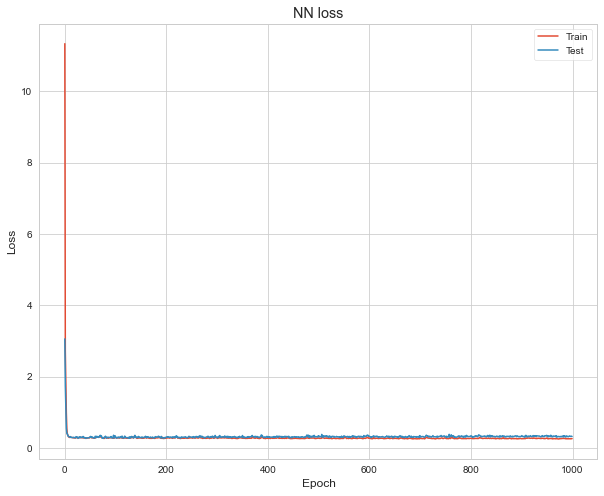

In [35]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('linear')
#plt.grid()
plt.legend()
plt.title('NN loss')
plt.show()

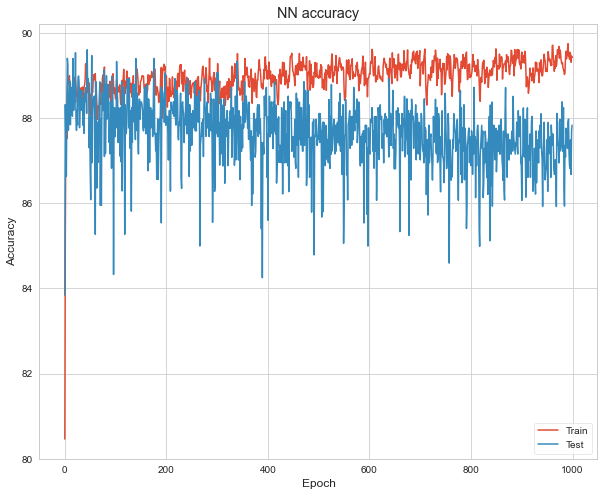

In [36]:
# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('linear')
#plt.grid()
plt.legend()
plt.title('NN accuracy')
plt.show()

### Evaluation Metrics

### Confusion Matrix

[[2378461   87539]
 [ 213393  260607]]


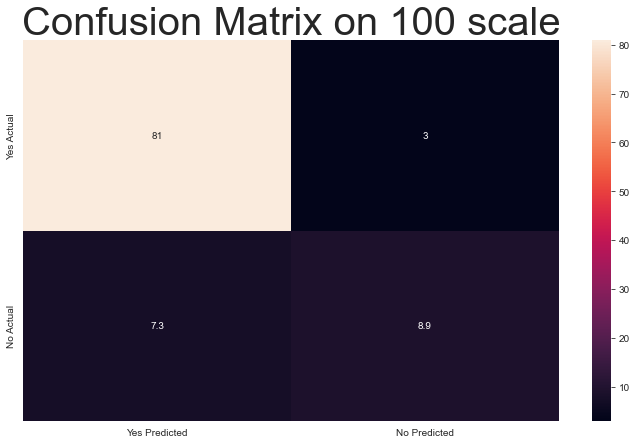

In [37]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, r2_score
import seaborn as sn
classes = ('Yes', 'No')
# Make all non 1 values 0
for i in range(len(predicted_targets)):
    if predicted_targets[i] != 1:
        predicted_targets[i] = 0
cf_matrix = confusion_matrix(actual_targets, predicted_targets)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, 
                     index = [f'{i} Actual'  for i in classes],
                     columns = [f'{i} Predicted' for i in classes])

plt.figure(figsize = (12,7))
heatmap = sn.heatmap(df_cm, annot=True)
title = heatmap.set_title('Confusion Matrix on 100 scale', fontsize = 40)

### Key Metrics

In [38]:
recall = recall_score(actual_targets, predicted_targets, average = 'weighted')
precision = precision_score(actual_targets, predicted_targets, average = 'weighted')
f1_score = f1_score(actual_targets, predicted_targets, average='weighted')
r2_score = r2_score(actual_targets, predicted_targets)
print('Key Metrics:\n')
print("Recall Score: \t\t{:.5f}".format(np.mean(recall)))
print("Precision Score: \t{:.5f}".format(np.mean(precision)))
print("F1 Score: \t\t{:.5f}".format(np.mean(f1_score)))
print("R2 Score: \t\t{:.5f}".format(np.mean(r2_score)))

Key Metrics:

Recall Score: 		0.89764
Precision Score: 	0.89040
F1 Score: 		0.89108
R2 Score: 		0.24309


### Integrated Gradients

In [39]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(net)
tensor_features.requires_grad_()
attr, delta = ig.attribute(tensor_features,target=1, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

Average Feature Importances
MonthlyRate :  21.610
MonthlyIncome :  -14.062
BusinessTravel :  5.096
StockOptionLevel :  -4.551
NumCompaniesWorked :  -3.840
Education :  -3.531
RelationshipSatisfaction :  3.013
JobInvolvement :  -2.617
OverTime :  2.387
PercentSalaryHike :  -2.381
EducationField_Life_Sciences :  -2.273
JobRole_Research_Scientist :  -2.202
Age :  2.155
EnvironmentSatisfaction :  1.942
JobSatisfaction :  1.810
HourlyRate :  -1.770
DailyRate :  -1.477
JobLevel :  1.356
WorkLifeBalance :  -1.233
Department_Research_Development :  -1.219
TotalWorkingYears :  1.190
YearsInCurrentRole :  -1.142
TrainingTimesLastYear :  -0.766
JobRole_Healthcare_Representative :  -0.678
JobRole_Laboratory_Technician :  0.652
JobRole_Manager :  -0.606
Gender :  0.548
YearsWithCurrManager :  0.513
MaritalStatus_Married :  0.471
JobRole_Manufacturing_Director :  -0.363
JobRole_Sales_Executive :  0.276
YearsAtCompany :  -0.259
EducationField_Medical :  -0.205
EducationField_Technical_Degree :  0.180

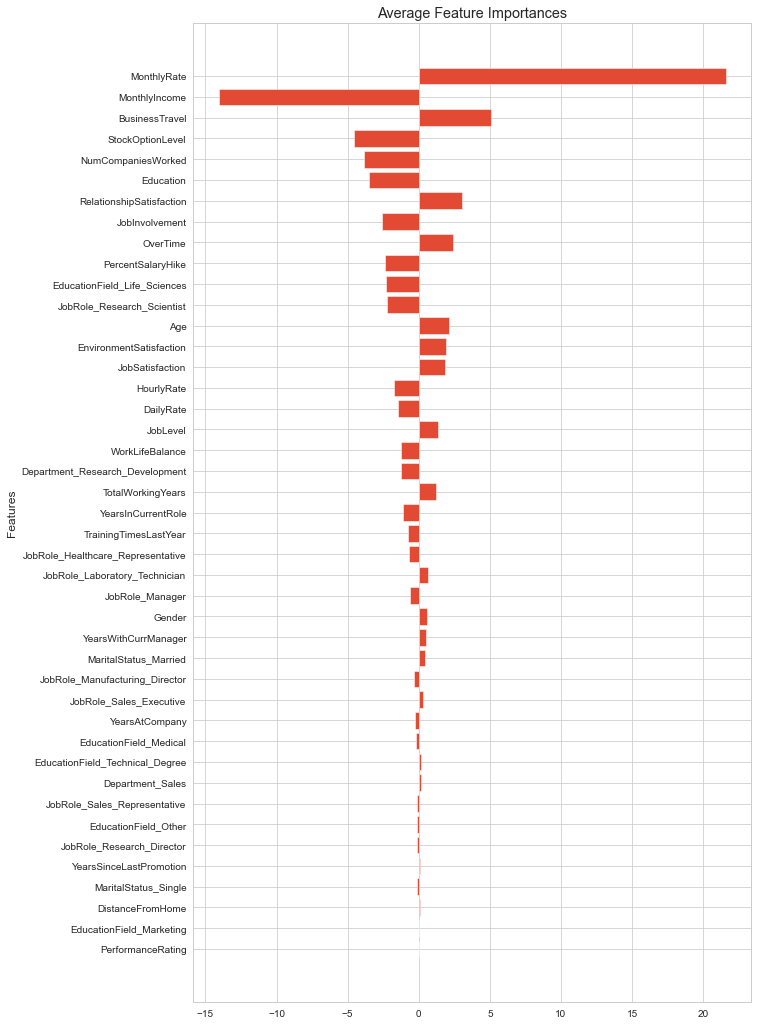

In [40]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    sorted_indexes = np.argsort(abs(importances))
    for i in sorted_indexes[::-1]:
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))

    sorted_importances = [importances[i] for i in sorted_indexes]
    sorted_feature_names = [feature_names[i] for i in sorted_indexes]
    if plot:
        plt.figure(figsize=(10,18))
        plt.barh(x_pos , sorted_importances, align='center')
        plt.yticks(x_pos, sorted_feature_names, wrap=True)
        plt.ylabel(axis_title)
        plt.title(title)

feature_names = list(df_features.columns)
visualize_importances(feature_names, np.mean(attr, axis=0))